## Using IRASA together with MNE Python

MNE Python offers a great beginner level interface to start analysing electrophysiological data.
If you are already familiar with MNE Python it is very easy to integrate PyRASA in your existing workflow.
This example notebook shows how to use PyRASA on your raw and epoched data.

In [1]:
import sys
from neurodsp.sim import sim_combined
import numpy as np
import scipy.signal as dsp
import matplotlib.pyplot as plt

import pandas as pd

sys.path.append('../')
import seaborn as sns

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

import mne
from mne.datasets import sample

from pyrasa.irasa_mne import irasa_raw, irasa_epochs

%matplotlib inline

We start by loading some MNE example data. More information about the dataset can be obtained from here TODO: insert link

In [2]:

data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"

meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"


raw = mne.io.read_raw_fif(raw_fname)
picks = mne.pick_types(raw.info, meg='mag', eeg=False, 
                       stim=False, eog=False, exclude="bads")
raw.pick(picks)

Opening raw data file /Users/fabian.schmidt/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,102 Magnetometers
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


We start by using the irasa_raw function. This function can be directly applied to your mne raw data object and will return a `AperiodicSpectrumArray` and a `PeriodicSpectrumArray` class. Both of the returned data classes are children from the MNE SpectrumArray class and allow you to use both the internal mne based plotting and analysis methods, as well as some specific methods to further investigate your aperiodic and periodic data.

A strength of IRASA is that the user needs to specify relatively few parameters to seperate periodic from aperiodic activity. Actually its really only one parameter that is the hset, which specifies the up- and downsampling factors IRASA uses.

However, misspecifications of hset can have can have severe consequences (see introduction to IRASA) for specifics regarding the algorithm and how things can go wrong. But dont worry the IRASA MNE functions are defined in a way that will throw an error in case you accidently fit models that are error prone and will tell you how you should specify your parameters such that everything should run smoothely.

Try changing the input to "band=(0.25, 100)" and see what happens :)

In [3]:
irasa_results = irasa_raw(raw, 
                          band=(.25, 50), 
                          duration=2, 
                          hset_info=(1.,2.,.05))

Now we can start investigating the returned `AperiodicSpectrumArray` and `PeriodicSpectrumArray` classes. 

You can use the basic plotting functions to compare the irasa'ed results to the classic power spectrum.

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/var/folders/6x/k2wvgw51691cj5qd77pzcrfw0000gn/T/ipykernel_29797/1044382114.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd(method='welch', n_per_seg=nperseg, n_overlap=nperseg//2, fmin=0.25, fmax=50).plot(axes=axes[0])
/Users/fabian.schmidt/git/pyrasa/.pixi/envs/default/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/6x/k2wvgw51691cj5qd77pzcrfw0000gn/T/ipykernel_29797/1044382114.py:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  irasa_results.aperiodic.plot(axes=axes[1])


Plotting power spectral density (dB=False).


/Users/fabian.schmidt/git/pyrasa/pyrasa/irasa_mne/mne_objs.py:61: UserWarning: Zero value in PSD for channels MEG 0111, MEG 0121, MEG 0131, MEG 0141, MEG 0211, MEG 0221, MEG 0231, MEG 0241, MEG 0311, MEG 0321, MEG 0331, MEG 0341, MEG 0411, MEG 0421, MEG 0431, MEG 0441, MEG 0511, MEG 0521, MEG 0531, MEG 0541, MEG 0611, MEG 0621, MEG 0631, MEG 0641, MEG 0711, MEG 0721, MEG 0731, MEG 0741, MEG 0811, MEG 0821, MEG 0911, MEG 0921, MEG 0931, MEG 0941, MEG 1011, MEG 1021, MEG 1031, MEG 1041, MEG 1111, MEG 1121, MEG 1131, MEG 1141, MEG 1211, MEG 1221, MEG 1231, MEG 1241, MEG 1311, MEG 1321, MEG 1331, MEG 1341, MEG 1411, MEG 1421, MEG 1431, MEG 1441, MEG 1511, MEG 1521, MEG 1531, MEG 1541, MEG 1611, MEG 1621, MEG 1631, MEG 1641, MEG 1711, MEG 1721, MEG 1731, MEG 1741, MEG 1811, MEG 1821, MEG 1831, MEG 1841, MEG 1911, MEG 1921, MEG 1931, MEG 1941, MEG 2011, MEG 2021, MEG 2031, MEG 2041, MEG 2111, MEG 2121, MEG 2131, MEG 2141, MEG 2211, MEG 2221, MEG 2231, MEG 2241, MEG 2311, MEG 2321, MEG 2331, 

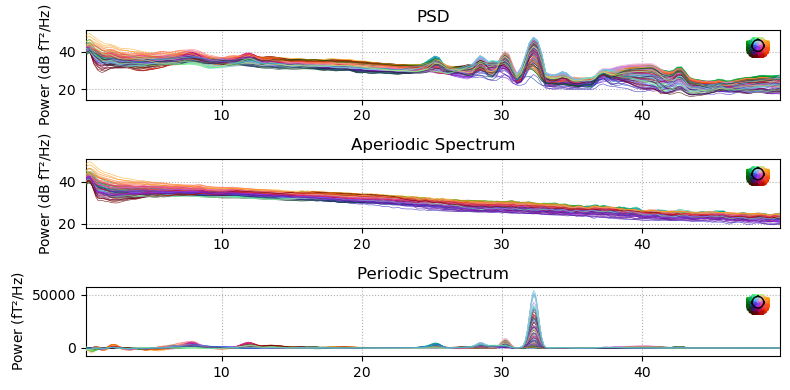

In [4]:
f, axes = plt.subplots(nrows=3, figsize=(8, 4))

nperseg = int(raw.info['sfreq']*2)
raw.compute_psd(method='welch', n_per_seg=nperseg, n_overlap=nperseg//2, fmin=0.25, fmax=50).plot(axes=axes[0])
irasa_results.aperiodic.plot(axes=axes[1])
irasa_results.periodic.plot(axes=axes[2])

axes[0].set_title('PSD')
axes[1].set_title('Aperiodic Spectrum')
axes[2].set_title('Periodic Spectrum')

f.tight_layout()

Now lets further investigate the returned spectra, by doing some slope fitting on the `AperiodicSpectrumArray` or trying to detect some putative oscillations in the `PeriodicSpectrumArray`. Generally speaking this is not necessary as you could just stop at this point and simply compare either periodic or aperiodic spectra directly across different subjects or experimental conditions, but sometimes we have specific expectations/assumptions about certain parameters of interest in a power spectrum and its therefore a good idea to parametrize our spectra early on.

Lets start with the `AperiodicSpectrumArray`: 
Here we can use the `get_slopes` method to extract two pandas dataframes. One containing the aperiodic parameters extracted from the data and another containing information about how well these parameters explained variance in the data.

The `get_slopes` method allows you to specify different methods to model your aperiodic spectrum. You can choose between a `fixed` and a `knee` mode similarly to specparam. However, it is worth noting that the `knee` fitting in PyRASA is slightly different as it allows you to fit two slopes and a knee.

You can also limit the range of your slope fit to a specific frequency range of interest (e.g. 30-40Hz). However, be aware that large freqeuency ranges are usually preferable, as decreasing your frequency range of interest too much usually results in a worse model fit (see Ameen et al. 2024). However, in some cases this decision might be viable e.g. understanding differences in E/I ratios (see Gao et al. 2017).

Lets start by comparing a `fixed` to a `knee` model fit. 


Text(0.5, 0, 'R2')

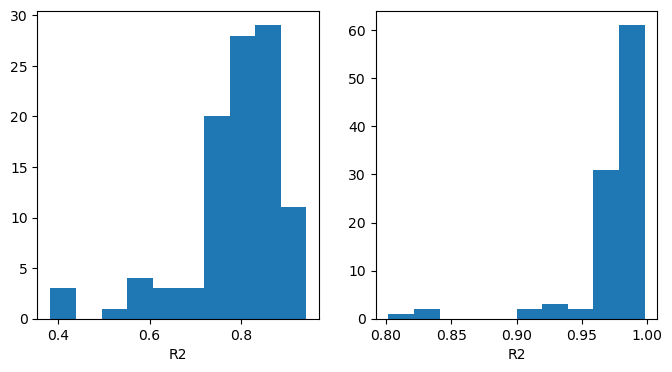

In [5]:
fixed_model = irasa_results.aperiodic.get_slopes(fit_func='fixed', scale=True, fit_bounds=[.5, 45])
knee_model = irasa_results.aperiodic.get_slopes(fit_func='knee', scale=True, fit_bounds=[.5, 45]);


f, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].hist(fixed_model.gof['r_squared']);
ax[0].set_xlabel('R2')
ax[1].hist(knee_model.gof['r_squared']);#
ax[1].set_xlabel('R2')


(array([ 6.,  8., 11., 17., 17., 16.,  9., 12.,  4.,  2.]),
 array([ 8.14227952,  9.53481945, 10.92735938, 12.31989931, 13.71243924,
        15.10497917, 16.4975191 , 17.89005903, 19.28259896, 20.67513888,
        22.06767881]),
 <BarContainer object of 10 artists>)

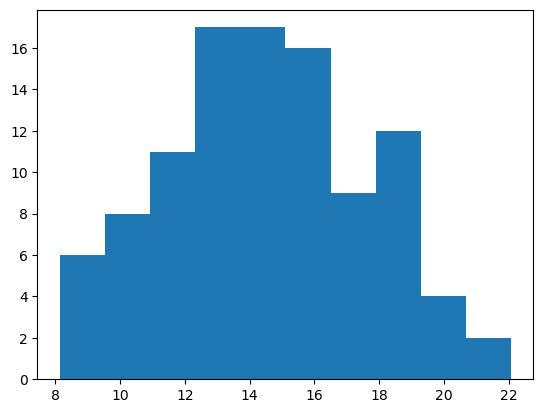

In [6]:
plt.hist(knee_model.aperiodic_params['Knee Frequency (Hz)'])

We can see that the `knee` model fit is explaining more variance of our data, but thats not enough to see whether the `knee` model is better than `fixed` model. You will soon be able to do this with IRASA by using information criteria :)

Now lets look at epoched data and investigate event related changes in periodic and aperiodic activity.
Lets start by loading the events.

In [7]:
#%% now lets check-out the events
event_id = {
    "Auditory/Left": 1,
    "Auditory/Right": 2,
    "Visual/Left": 3,
    "Visual/Right": 4,
}
tmin = -0.2
tmax = 0.5

# Load real data as the template
event_fname = meg_path / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(event_fname)


epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    #picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)

Now we can just use the `irasa_epochs` function to get periodic and aperiodic data per epoch.
This is of course super noisy at the single epoch level and should be averaged.

In [8]:
irasa_epoched = irasa_epochs(epochs, 
                                   band=(.5, 50), 
                                   hset_info=(1.,2.,.05))

We can now again get the slopes. Other than in `raw` we also get the `event_id` as a column in our pandas dataframe which we can use to run e.g. statistics or to plot a change in exponents by condition.

In [9]:
knee_epoched = irasa_epoched.aperiodic.get_slopes(fit_func='knee', scale=True, fit_bounds=[1, 45])

/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/fit_funcs.py:146: RuntimeWarning: overflow encountered in power
  y_hat = Offset - np.log10(x**Exponent_1 * (Knee + x**Exponent_2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/fit_funcs.py:146: RuntimeWarning: overflow encountered in power
  y_hat = Offset - np.log10(x**Exponent_1 * (Knee + x**Exponent_2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/fit_funcs.py:146: RuntimeWarning: overflow encountered in multiply
  y_hat = Offset - np.log10(x**Exponent_1 * (Knee + x**Exponent_2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/fit_funcs.py:146: RuntimeWarning: overflow encountered in power
  y_hat = Offset - np.log10(x**Exponent_1 * (Knee + x**Exponent_2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/fit_funcs.py:146: RuntimeWarning: overflow encountered in multiply
  y_hat = Offset - np.log10(x**Exponent_1 * (Knee + x**Exponent_2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/fit_funcs.py:146: RuntimeWarning: overflow encountered in 

<Axes: xlabel='event_id', ylabel='Knee Frequency (Hz)'>

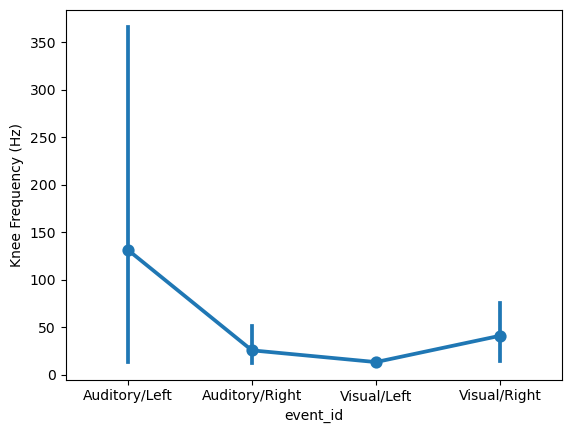

In [10]:
ap_data = knee_epoched.aperiodic_params.groupby(['event_id', 'ch_name'])['Knee Frequency (Hz)'].mean().reset_index()
sns.pointplot(ap_data, x='event_id', y='Knee Frequency (Hz)')

Similarly we can also analyse the periodic activity, by condition.

In [11]:
df_periodic = irasa_epoched.periodic.get_peaks(smoothing_window=2)

In [12]:
from pyrasa.utils.peak_utils import get_band_info
df_alpha = get_band_info(df_periodic, freq_range=(8,14), ch_names=df_periodic['ch_name'].unique())

<Axes: xlabel='event_id', ylabel='cf'>

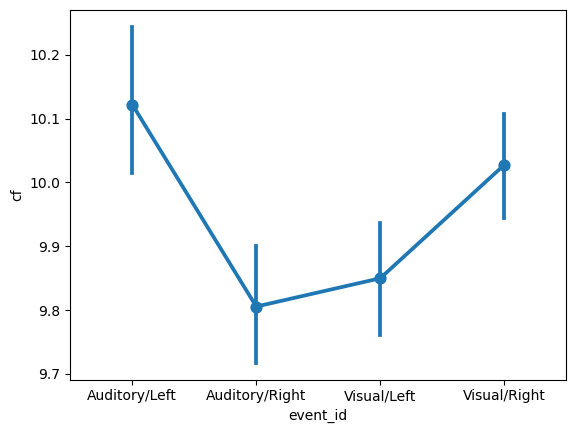

In [13]:
p_data = df_alpha.groupby(['event_id', 'ch_name'])['cf'].mean().reset_index()

sns.pointplot(p_data, x='event_id', y='cf')